In [264]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cartopy import crs as ccrs, feature as cfeature


# Plotting config 
plt.rcParams['figure.figsize'] = [12, 8]
%config InlineBackend.figure_format = "retina"

In [15]:
dataset = xr.open_dataset("data/HadCRUT.5.0.2.0.analysis.anomalies.1.nc")

In [16]:
# things to look at: 
# anom quartiles per year
# places with highest and lowest anomoly
# areas with lots of fluctuation
# areas that didn't move too much
# choose an area and graph its anomolies over a year
# are there trends in areas or is it global
# seasonal patterns

dataset

<xarray.Dataset> Size: 43MB
Dimensions:         (time: 2089, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2024-0...
  * latitude        (latitude) float64 288B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 576B -177.5 -172.5 ... 172.5 177.5
    realization     int64 8B ...
Dimensions without coordinates: bnds
Data variables:
    tas             (time, latitude, longitude) float64 43MB ...
    time_bnds       (time, bnds) datetime64[ns] 33kB ...
    latitude_bnds   (latitude, bnds) float64 576B ...
    longitude_bnds  (longitude, bnds) float64 1kB ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2024-02-27T15:32:53+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.2.0 HadSST.4.0.1.0
    title:        HadCRUT.5.0.2.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.2.0
    Conventions:  CF-1.7

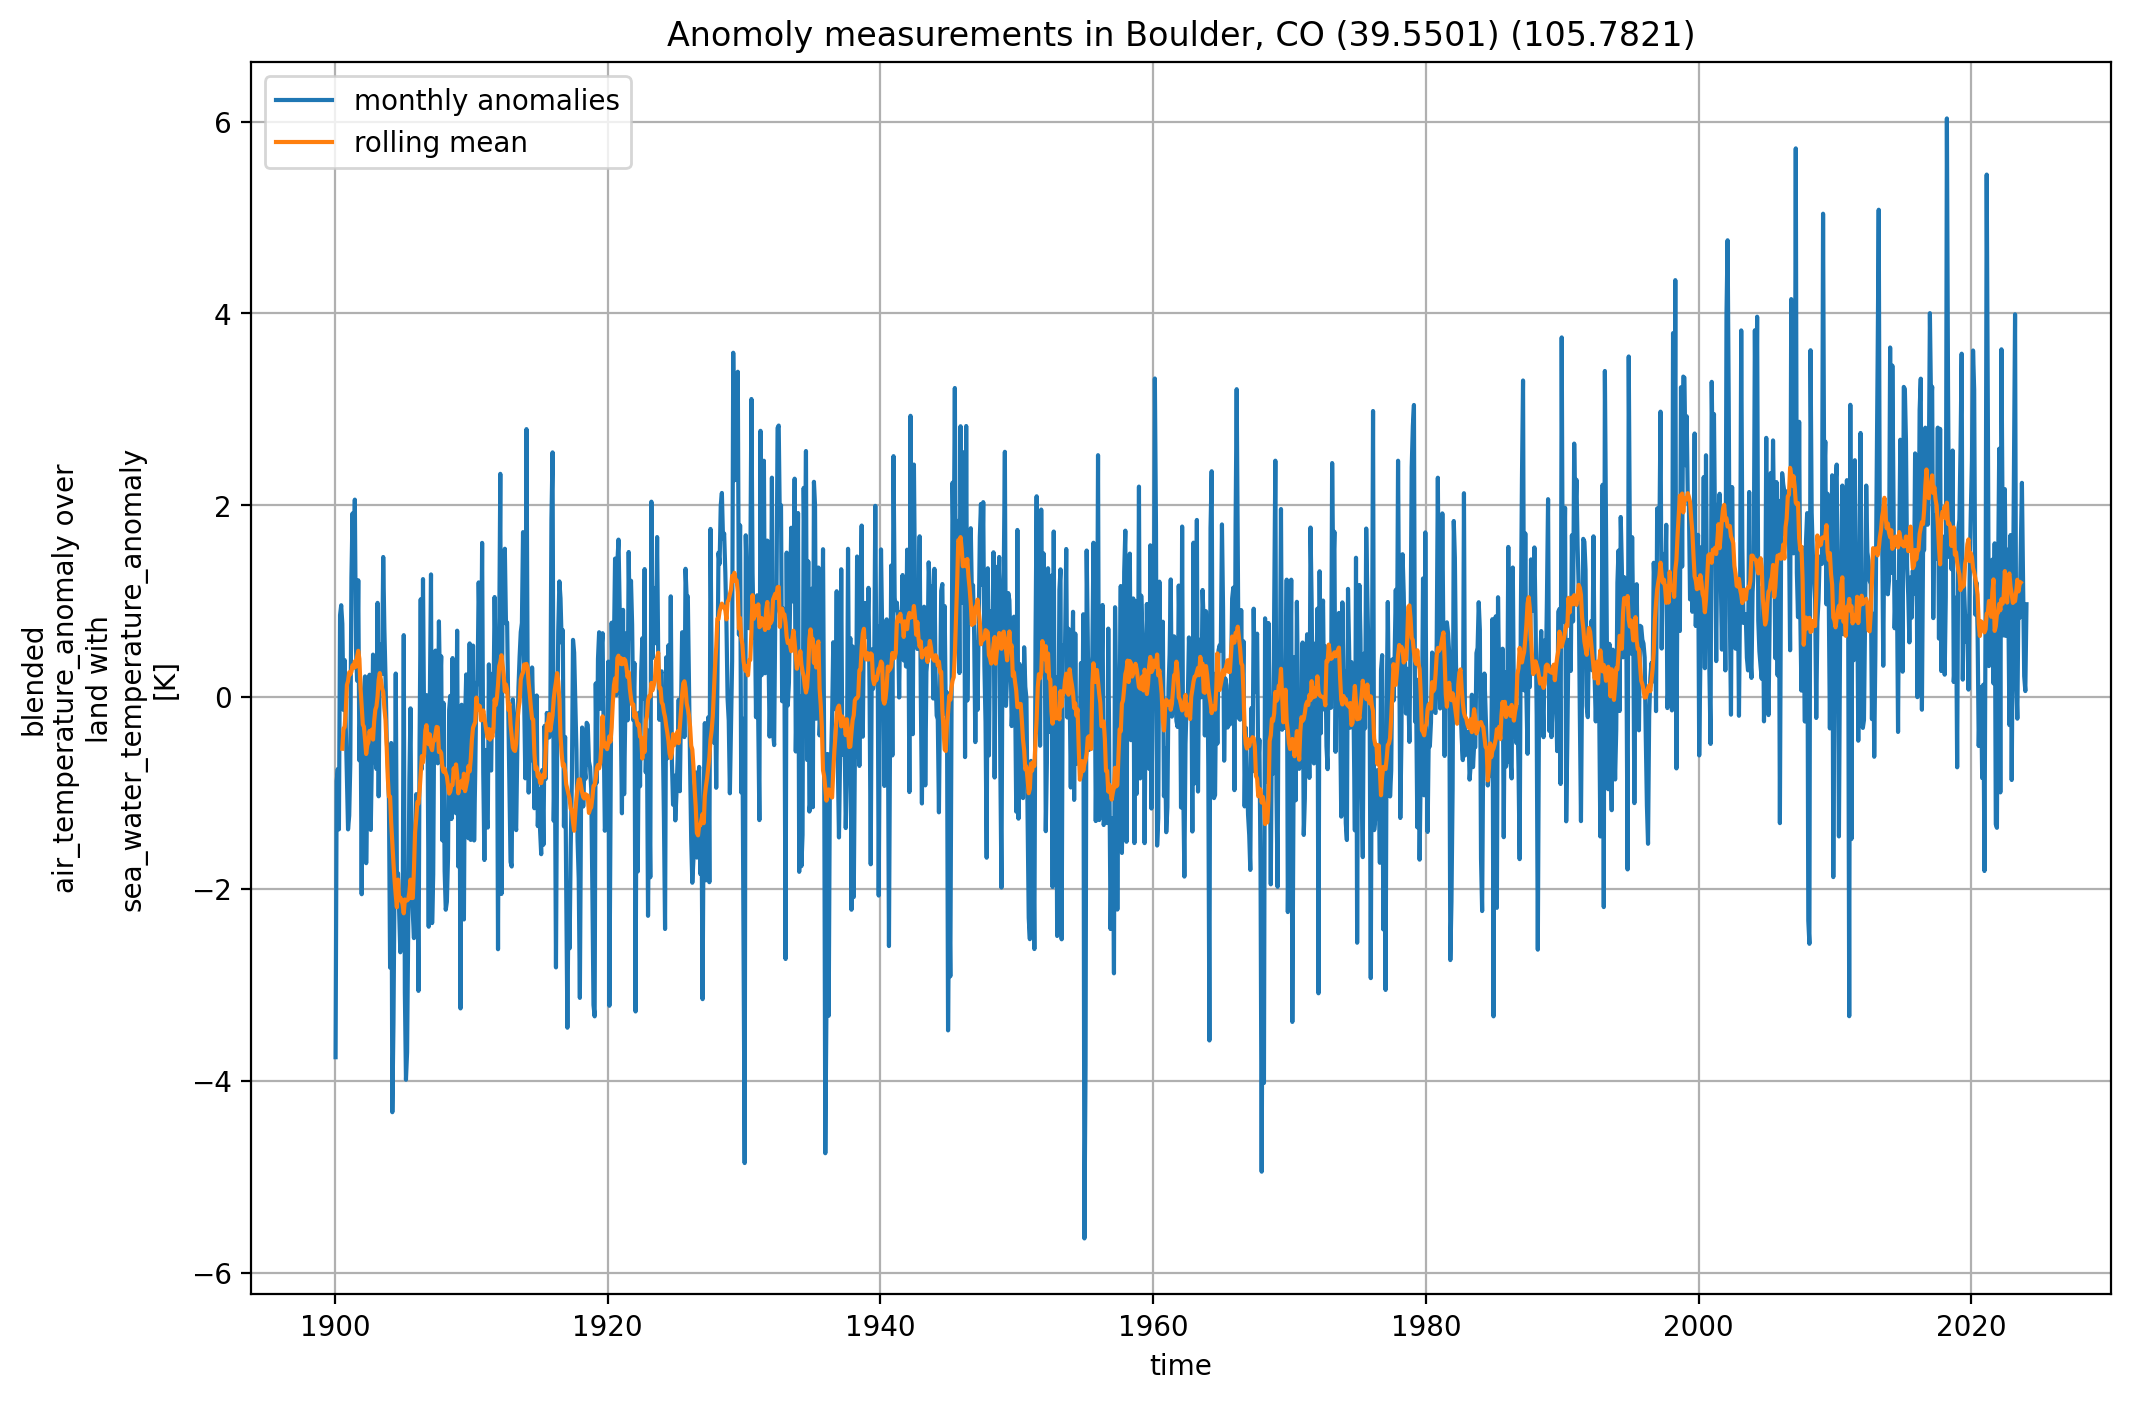

In [58]:
# Anomoly data for Boulder, CO 

boulder_lat, boulder_long = 39.5501, 105.7821
year_start, year_end = "1900", "2024"

# question: what's the baseline for anomoly? is that changing as temps rise?

# Individual data
boulder_anoms = dataset.tas.sel(
    latitude=boulder_lat, longitude=boulder_long, method="nearest"
).sel(
    time=slice(year_start, year_end)
)

boulder_anoms.plot(label='monthly anomalies')

# Rolling mean
rolling_mean = boulder_anoms.rolling(time=12, center=True).mean()
rolling_mean.plot(label='rolling mean')
plt.title(f"Anomoly measurements in Boulder, CO ({boulder_lat}) ({boulder_long})")
plt.legend()
plt.grid()
plt.show()

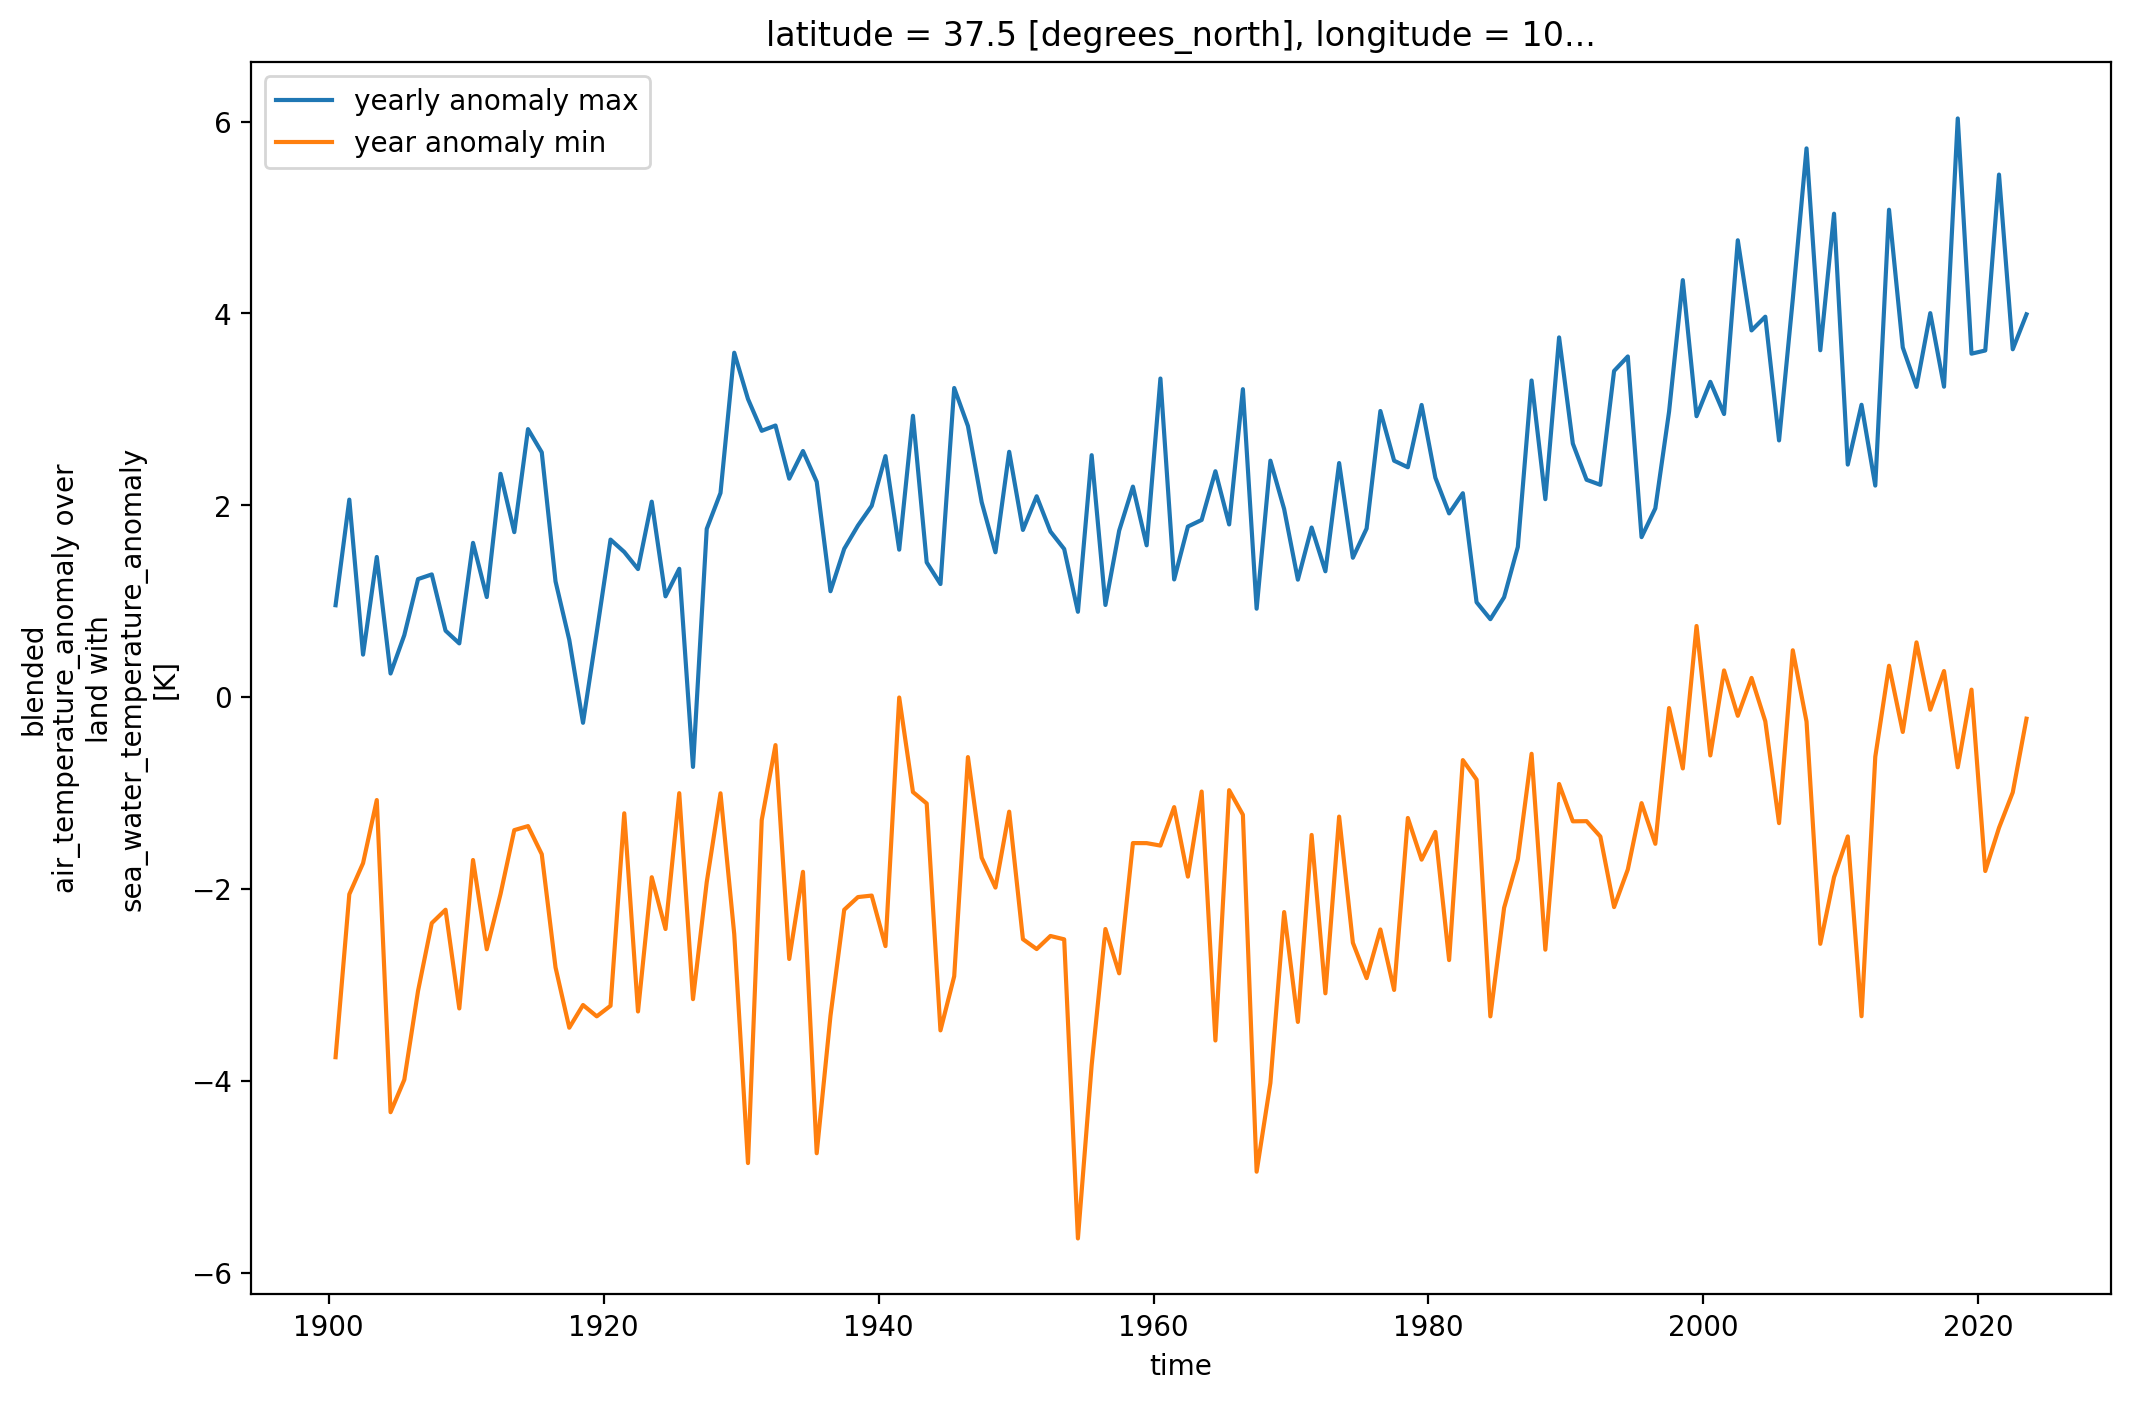

In [21]:
# Max and min anomolies by year, data for Boulder, CO 

boulder_coarse_yr = boulder_anoms.coarsen(time=12, boundary='trim')
boulder_maxes = boulder_coarse_yr.max()
boulder_mins = boulder_coarse_yr.min()

boulder_maxes.plot(label='yearly anomaly max')
boulder_mins.plot(label='year anomaly min')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Global minimum, maximum, and quartile anomalies')

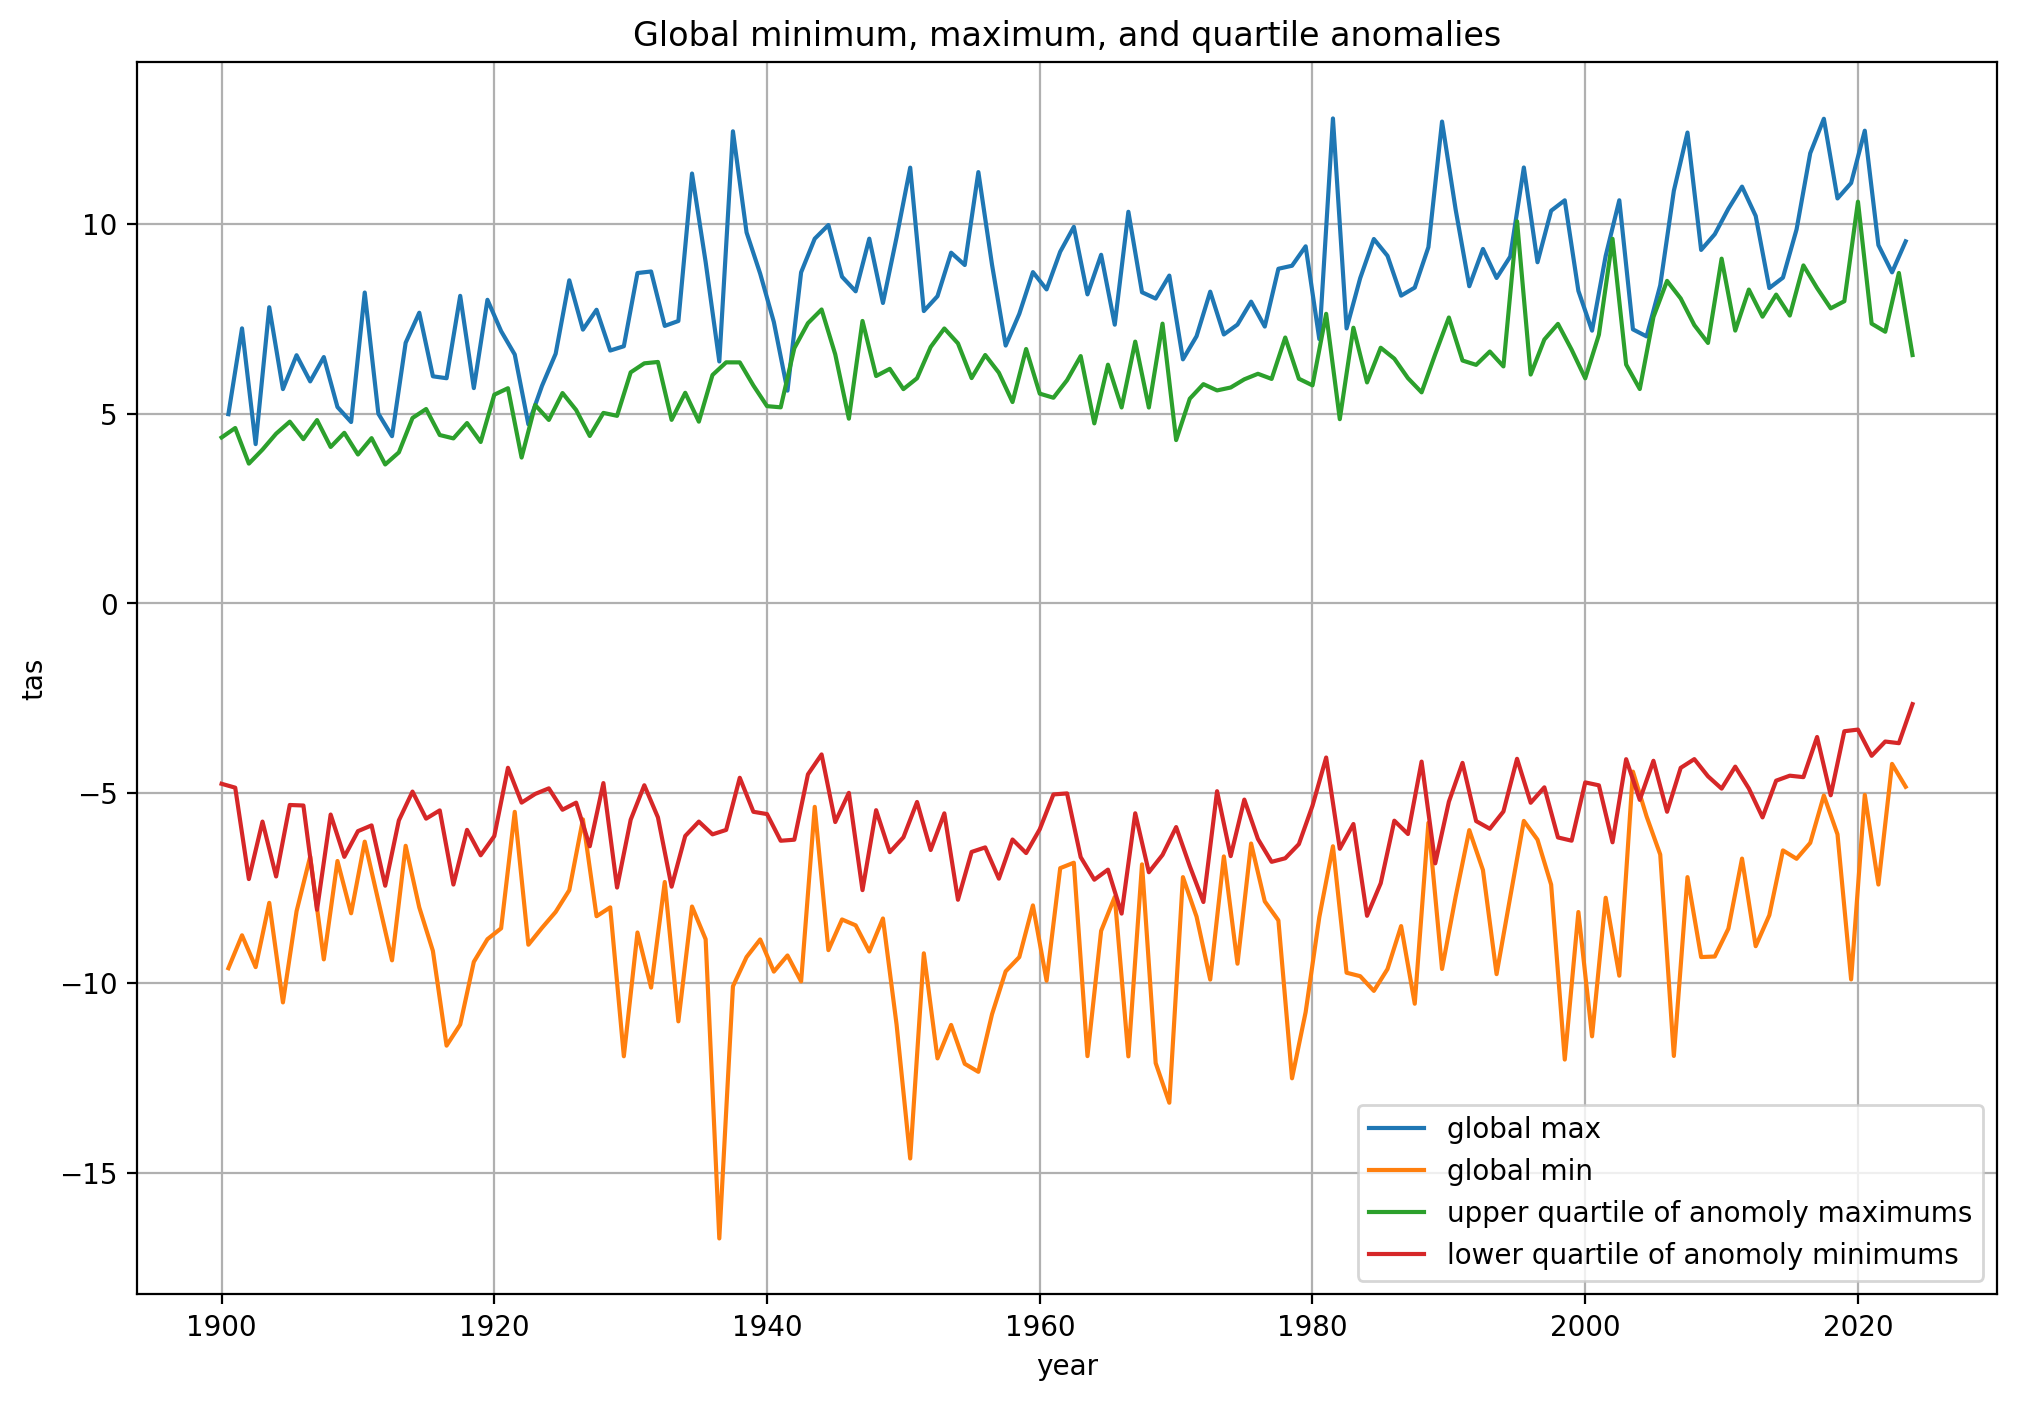

In [61]:
# Max and min anomolies by year, global

global_anoms_maxes = dataset.tas.sel(
    time=slice(year_start, year_end)
).max(dim='latitude').max(dim='longitude').coarsen(
    time=12, boundary='trim'
).max()

global_anoms_mins = dataset.tas.sel(
    time=slice(year_start, year_end)
).min(dim='latitude').min(dim='longitude').coarsen(
    time=12, boundary='trim'
).min()

global_anoms_maxes.plot(label='global max')
global_anoms_mins.plot(label='global min')



# # Maybe quantiles are better? 
global_anoms_upper_q = dataset.tas.sel(
    time=slice(year_start, year_end)
).max(dim='latitude').max(dim='longitude').groupby('time.year').quantile(0.75)
year_date_strs = [str(year) + "-01-01" for year in global_anoms_upper_q['year'].values]
global_anoms_upper_q['year'] = pd.DatetimeIndex(year_date_strs)
global_anoms_upper_q.plot(label='upper quartile of anomoly maximums')


global_anoms_lower_q = dataset.tas.sel(
    time=slice(year_start, year_end)
).min(dim='latitude').min(dim='longitude').groupby('time.year').quantile(0.25)
year_date_strs = [str(year) + "-01-01" for year in global_anoms_lower_q['year'].values]
global_anoms_lower_q['year'] = pd.DatetimeIndex(year_date_strs)
global_anoms_lower_q.plot(label='lower quartile of anomoly minimums')

plt.grid()
plt.legend()
plt.title("Global minimum, maximum, and quartile anomalies")

In [115]:
two_ds = dataset.sel(
    time=slice("2023-12", "2024-03"),
    latitude=slice(-88, -80),
    longitude=slice(-178, -170)
)

print(two_ds.latitude_bnds.values)
print(two_ds.latitude_bnds)
print("---------------")
print(two_ds.latitude_bnds.coords["latitude"].values)

# print(list(two_ds.latitude_bnds.coords["latitude"]))



# list(dataset.groupby("latitude", squeeze=False))

[[-90. -85.]
 [-85. -80.]]
<xarray.DataArray 'latitude_bnds' (latitude: 2, bnds: 2)> Size: 32B
array([[-90., -85.],
       [-85., -80.]])
Coordinates:
  * latitude     (latitude) float64 16B -87.5 -82.5
    realization  int64 8B 1
Dimensions without coordinates: bnds
---------------
[-87.5 -82.5]


In [72]:
print(dataset.time_bnds[0].coords)
print(dataset.time_bnds[0].realization)

Coordinates:
    time         datetime64[ns] 8B 1850-01-16T12:00:00
    realization  int64 8B 1
<xarray.DataArray 'realization' ()> Size: 8B
array(1)
Coordinates:
    time         datetime64[ns] 8B 1850-01-16T12:00:00
    realization  int64 8B 1
Attributes:
    units:          1
    standard_name:  realization


In [118]:
import cartopy.crs as ccrs

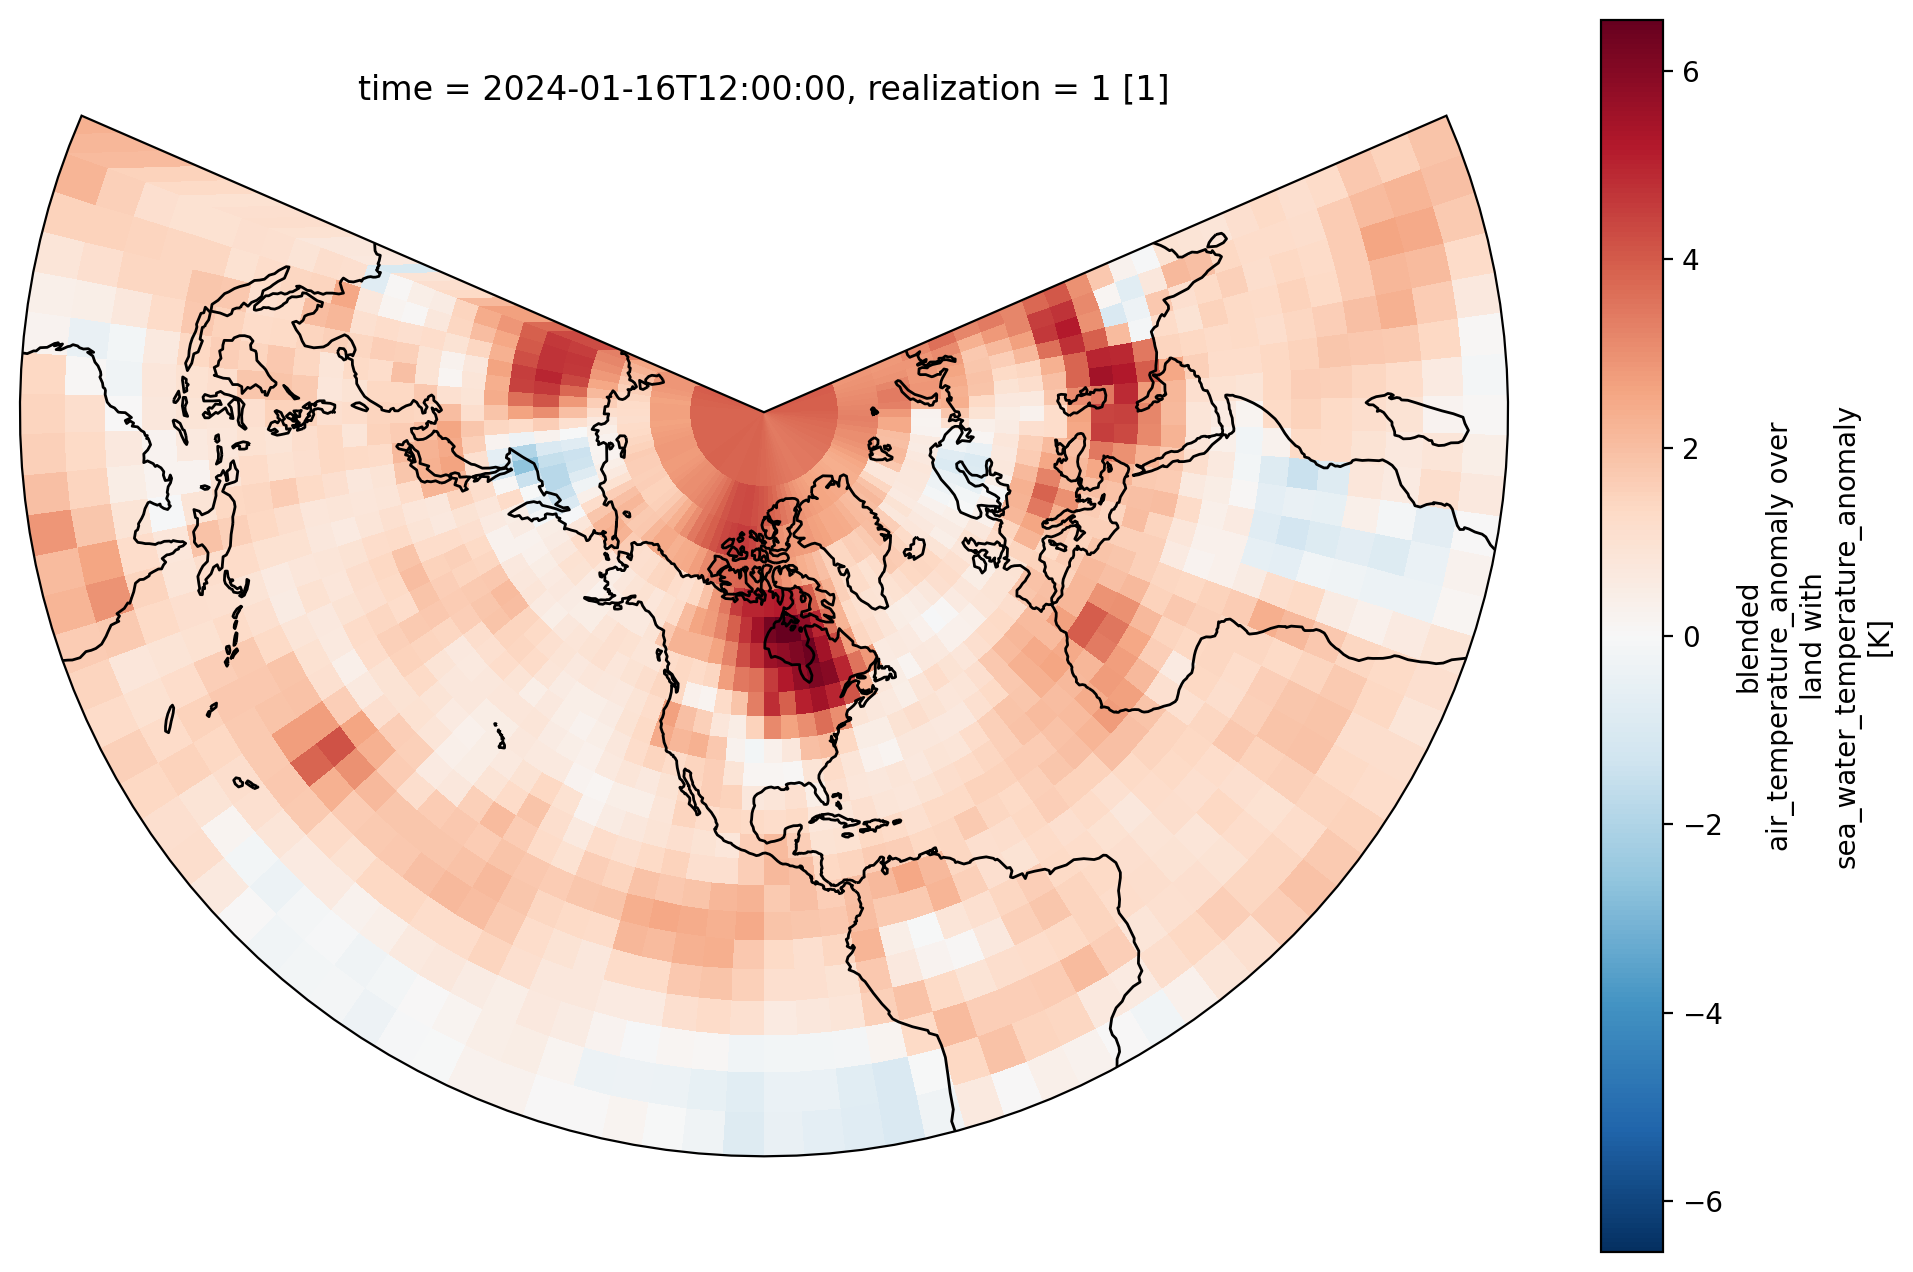

In [124]:
projection = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
f, ax = plt.subplots(subplot_kw=dict(projection=projection))
dataset.tas.isel(time=-1).plot(transform=ccrs.PlateCarree())
ax.coastlines()

In [138]:
weights = np.cos(np.deg2rad(dataset.tas.latitude))
weights.name = "weights"

In [ ]:
# w = (dataset.tas * weights).isel(time=-1).sel(latitude=90, method="nearest")
# uw = (dataset.tas).isel(time=-1).sel(latitude=90, method="nearest")

In [150]:
dataset_weighted = dataset.tas.weighted(weights)

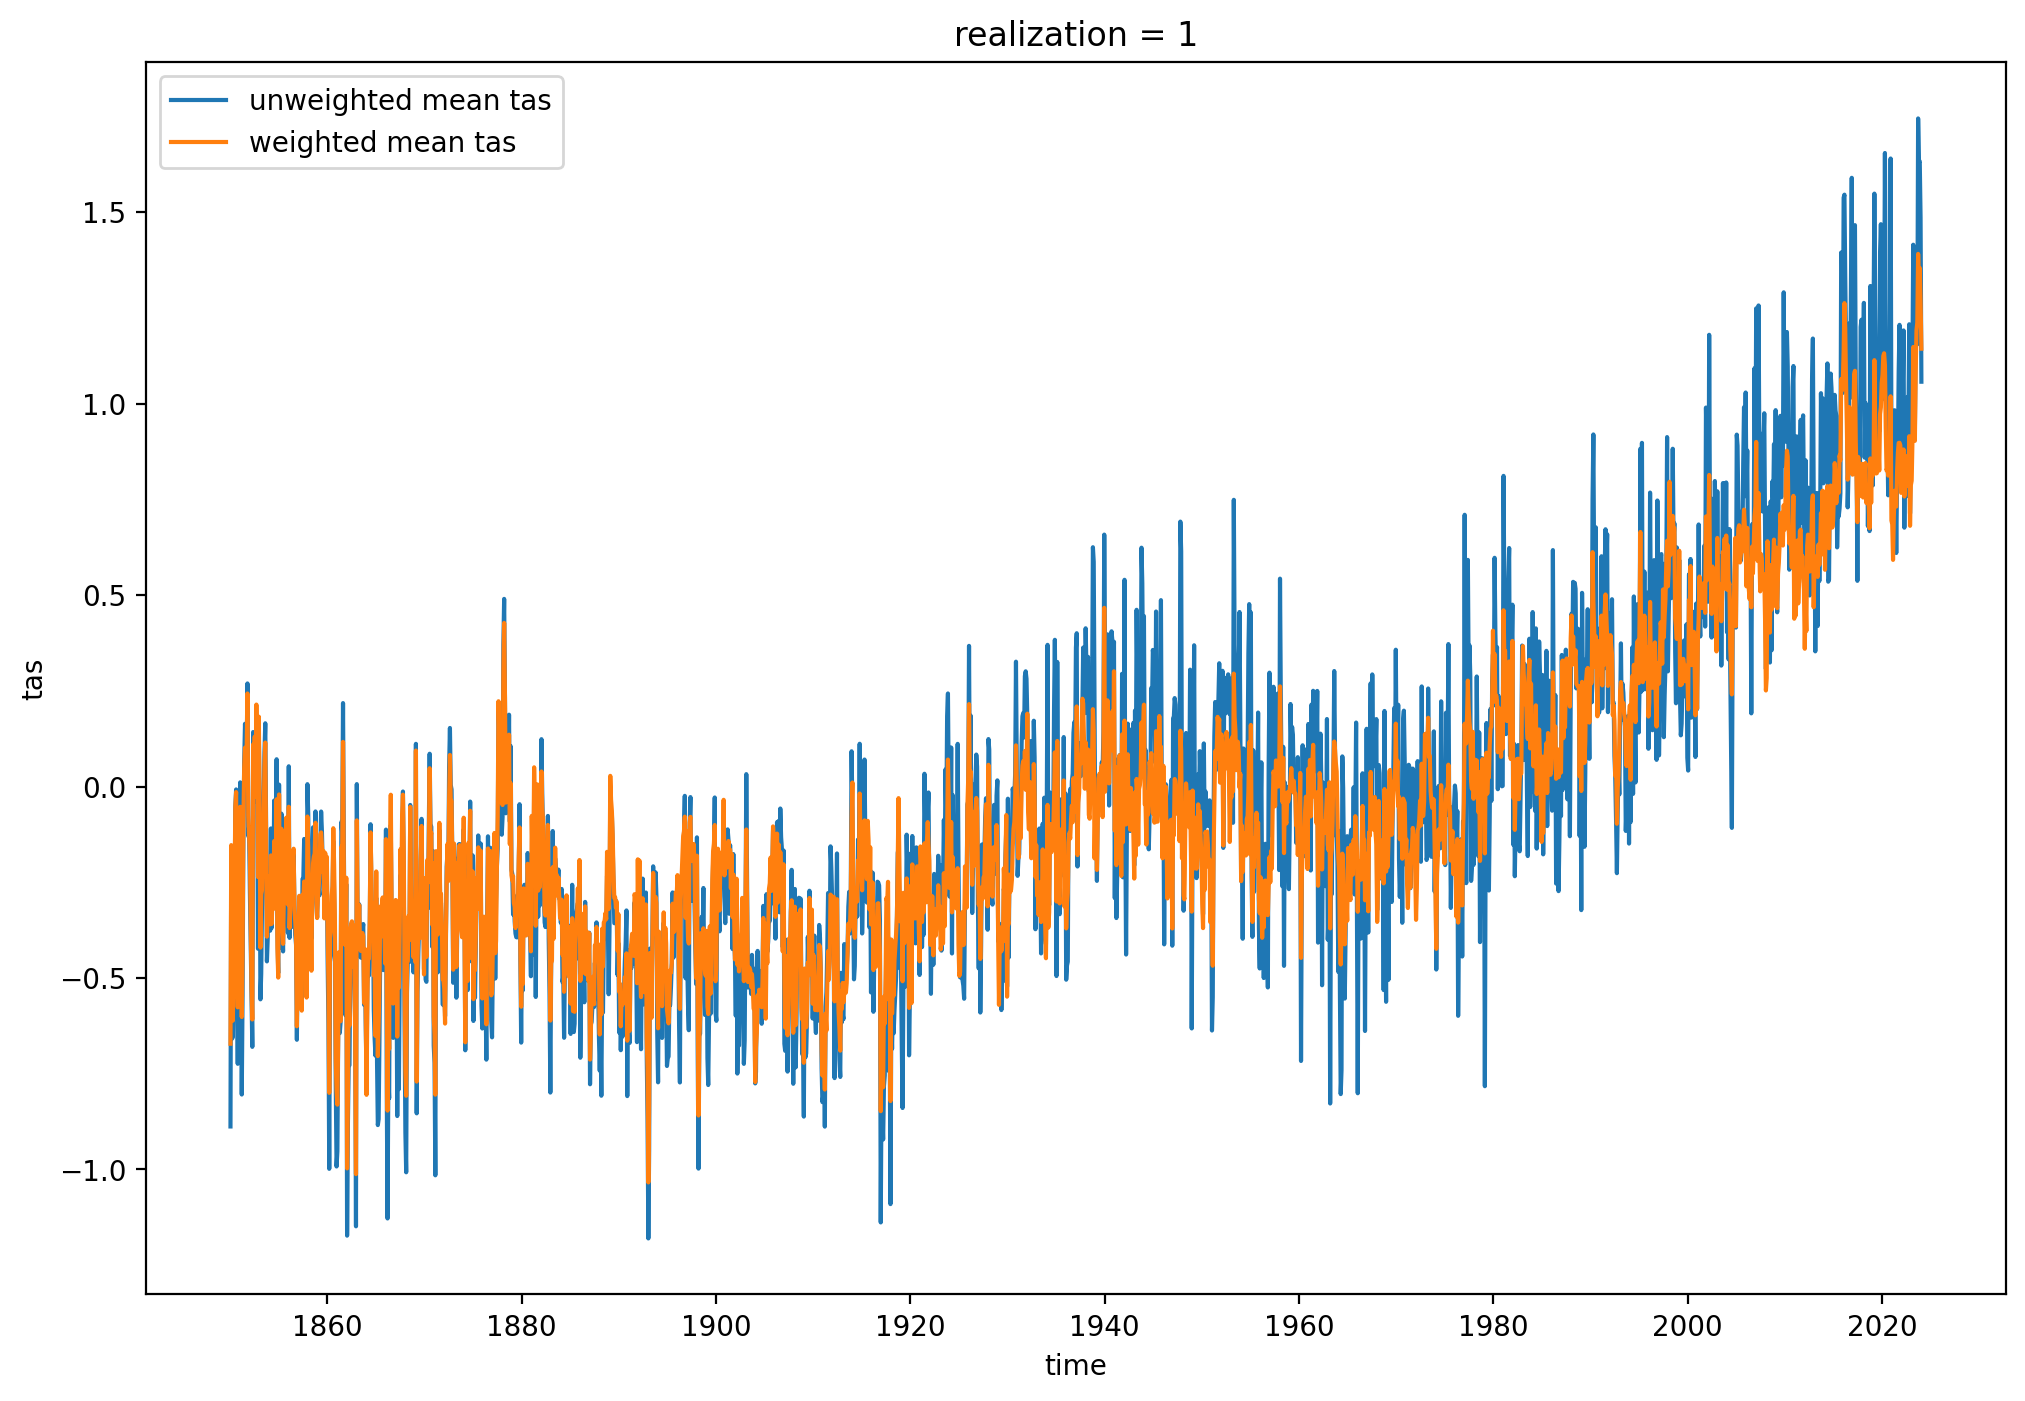

In [157]:
dataset.tas.mean(dim=("longitude", "latitude")).plot(label="unweighted mean tas")
dataset_weighted.mean(dim=("longitude", "latitude")).plot(label="weighted mean tas")

plt.legend()

In [160]:
diff = dataset.tas.mean(dim=("longitude", "latitude")) - dataset_weighted.mean(dim=("longitude", "latitude"))

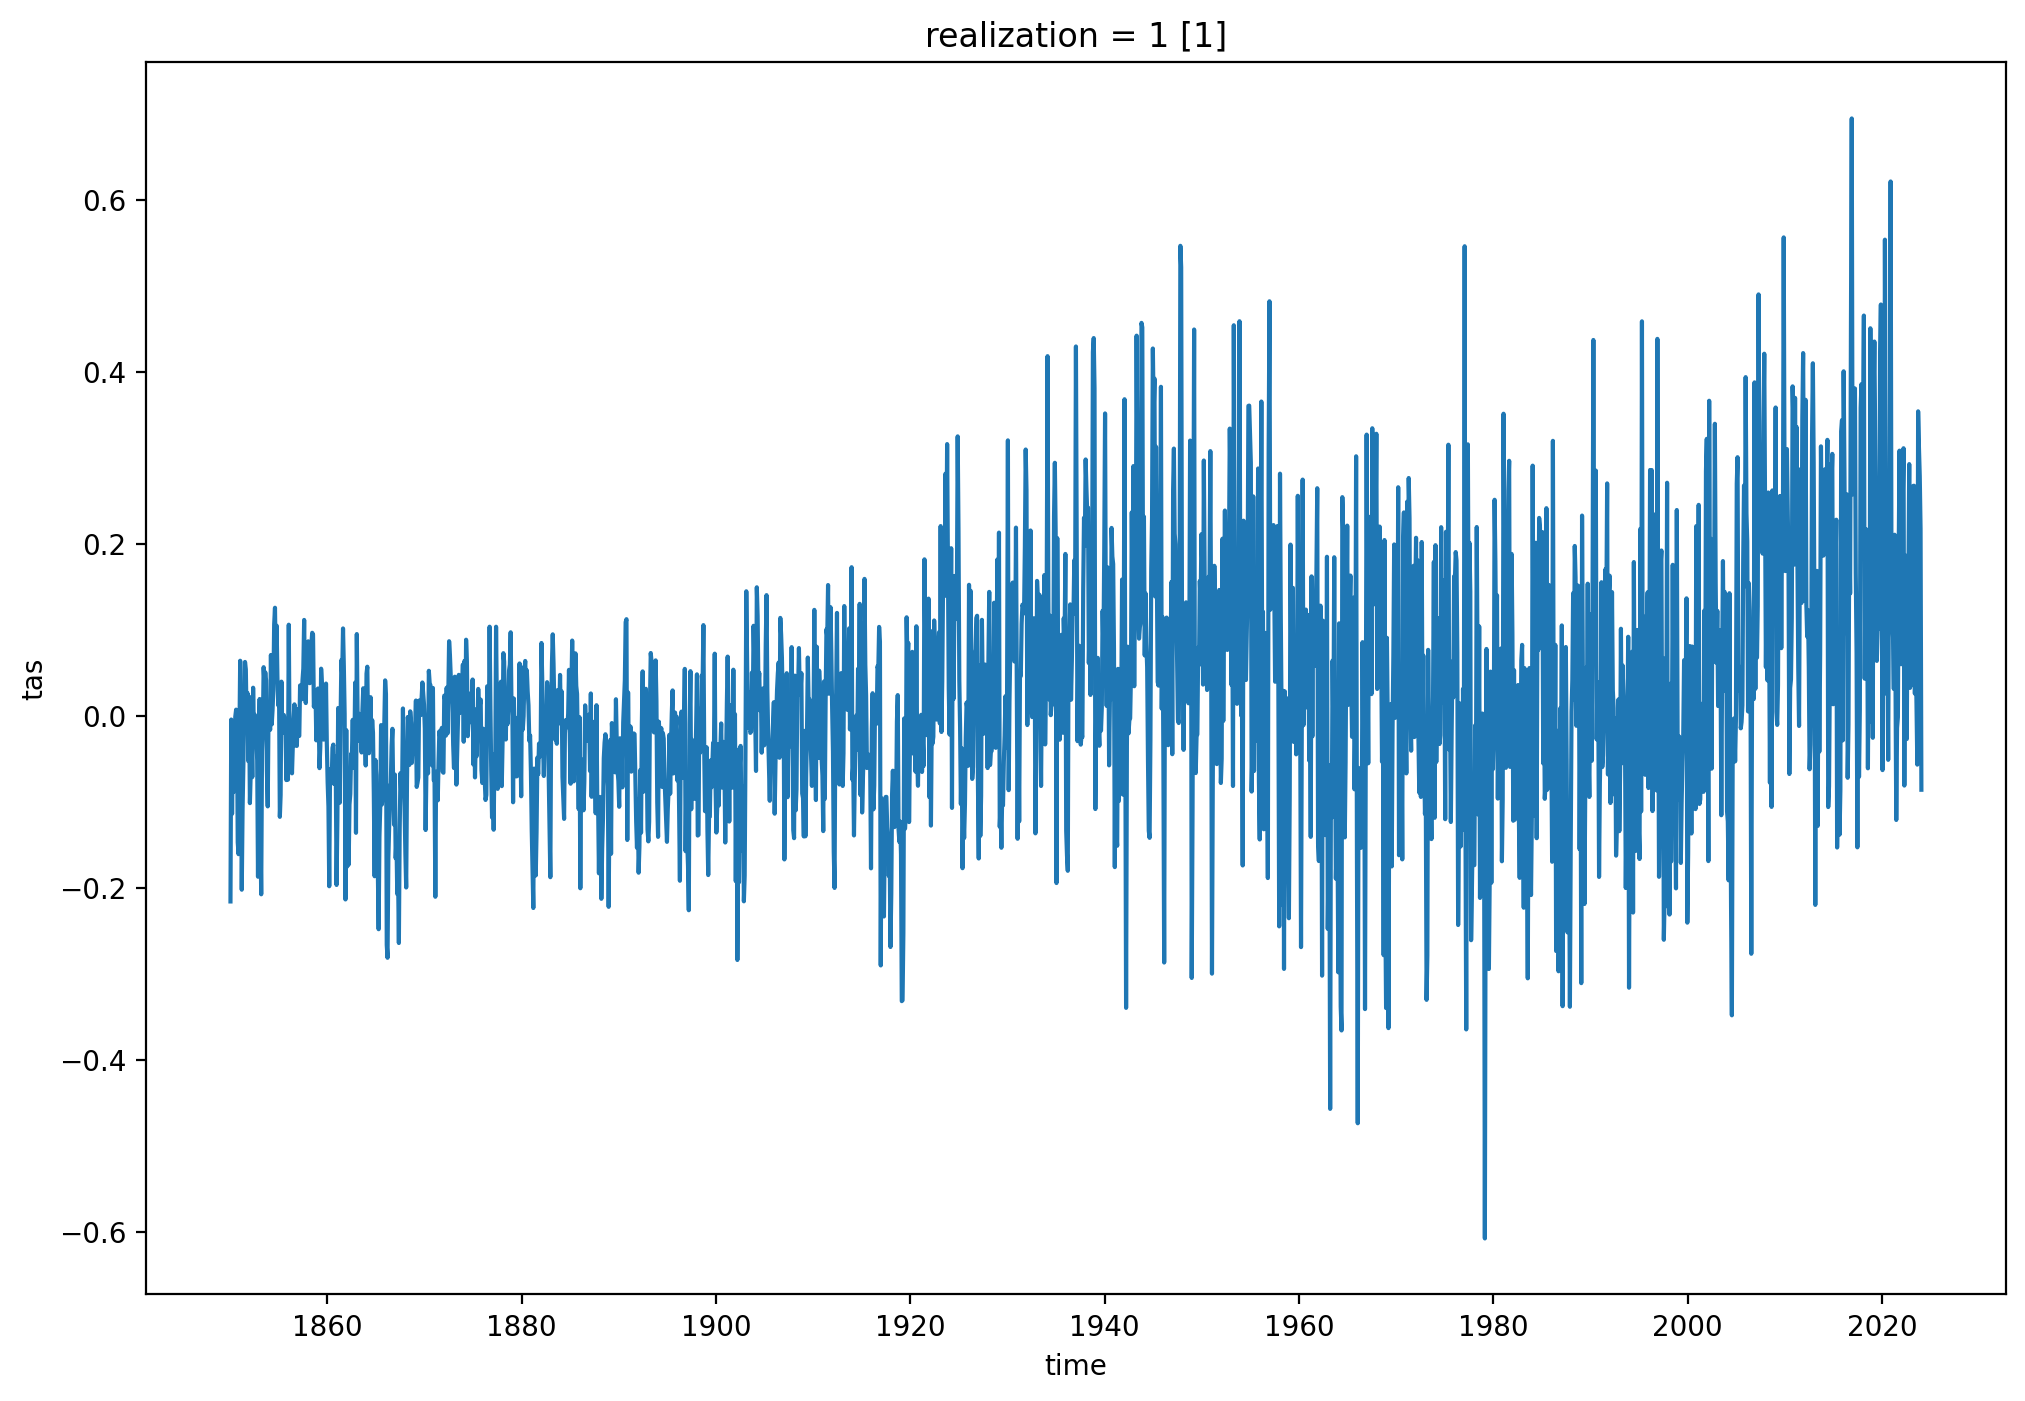

In [161]:
diff.plot()

<xarray.DataArray 'tas' (latitude: 36, longitude: 72)> Size: 21kB
array([[1.60360131, 1.59714685, 1.59085095, ..., 1.62047169, 1.61576449,
        1.60958911],
       [1.61925402, 1.61644418, 1.6092449 , ..., 1.6293439 , 1.62810109,
        1.62441722],
       [1.60073826, 1.58326518, 1.56706545, ..., 1.66911744, 1.63423448,
        1.62460886],
       ...,
       [2.11875923, 2.12481663, 2.13298613, ..., 2.14097562, 2.1342738 ,
        2.12642185],
       [2.02556628, 2.01922775, 2.01192215, ..., 2.05076731, 2.04491164,
        2.03828992],
       [1.99595051, 1.9886153 , 1.982476  , ..., 2.01365985, 2.00854151,
        2.00301595]])
Coordinates:
  * latitude     (latitude) float64 288B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude    (longitude) float64 576B -177.5 -172.5 -167.5 ... 172.5 177.5
    realization  int64 8B 1

In [185]:
tas_stds = dataset.tas.sel(time=slice("1960", "2023")).groupby('time.year').std()

In [186]:
earliest_std = tas_stds.isel(year=0)
latest_std = tas_stds.isel(year=-1)

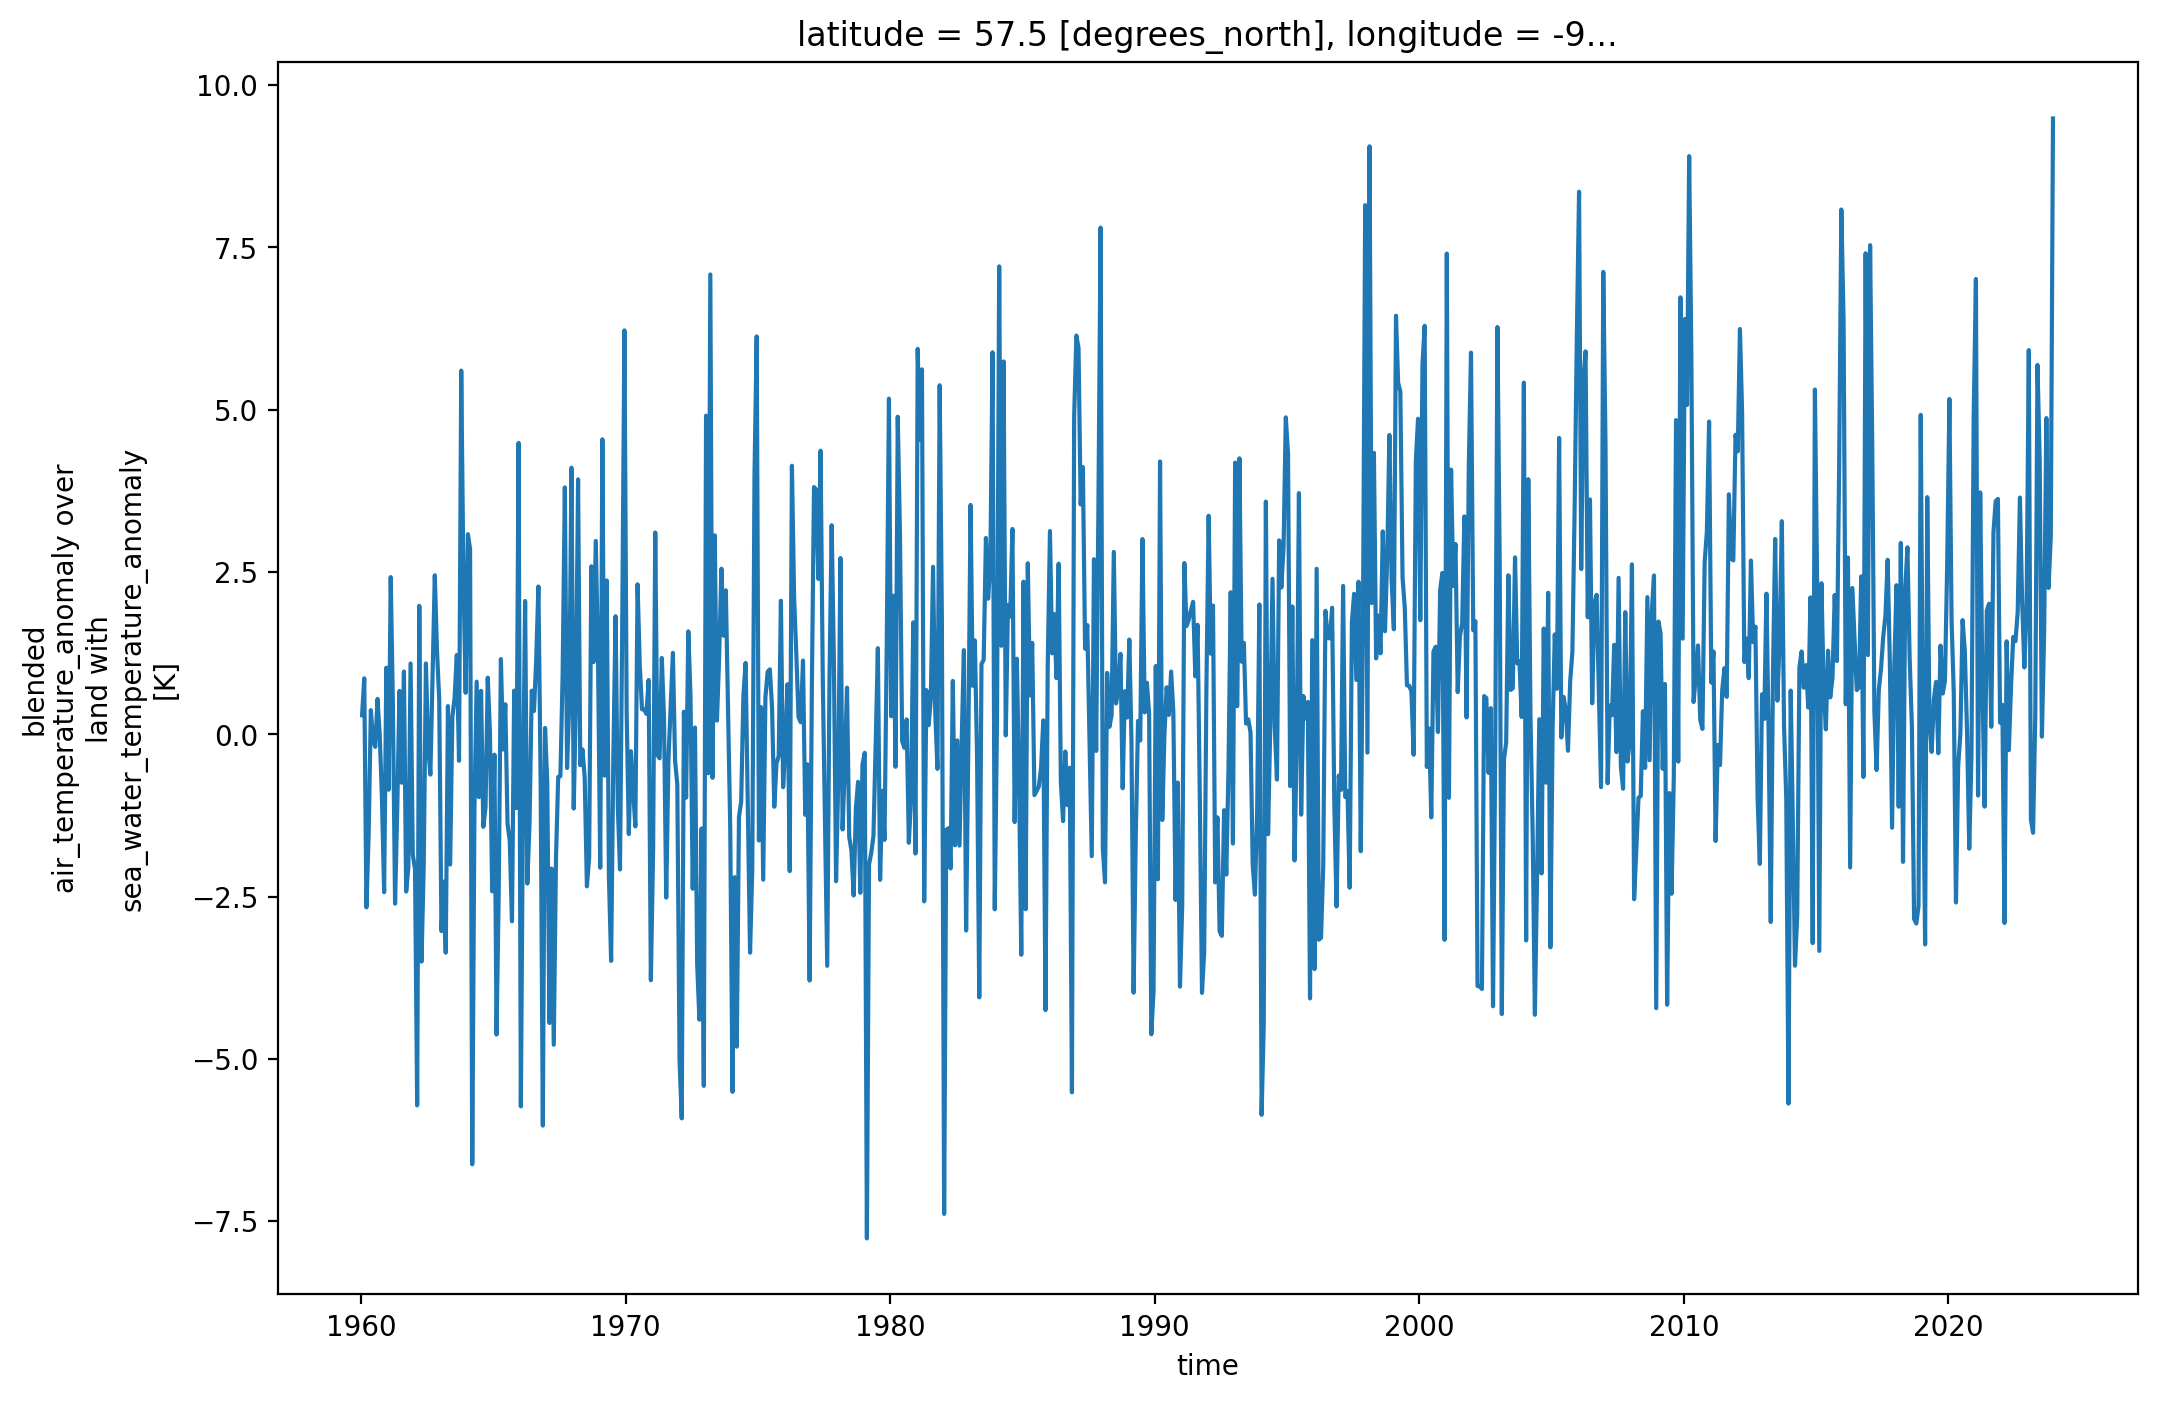

In [210]:
diff_std = latest_std - earliest_std
# diff_std[diff_std.argmax(dim="...")]
diff_std.argmax(...)
where = np.where(diff_std == diff_std.max())
dataset.tas.sel(latitude=57.5, longitude=-97.5, method='nearest').sel(time=slice("1960", "2023")).plot()

In [216]:
diff_std_df = diff_std.to_dataframe()
diff_std_df = diff_std_df[["tas"]]

In [220]:
diff_std_df.sort_values("tas")

tas
latitude longitude          
67.5      67.5     -1.363053
62.5     -177.5    -1.362653
67.5      62.5     -1.359013
72.5      67.5     -1.283329
          72.5     -1.279975
...                      ...
52.5     -107.5     1.569054
57.5     -92.5      1.723559
52.5     -102.5     1.785014
57.5     -102.5     1.847298
         -97.5      1.989570

[2592 rows x 1 columns]

In [242]:
# lets try to capture variation somehow :thinking-face:
ds = dataset.tas.sel(time=slice("1960", "2023"))
ds = ds.drop_vars("realization")

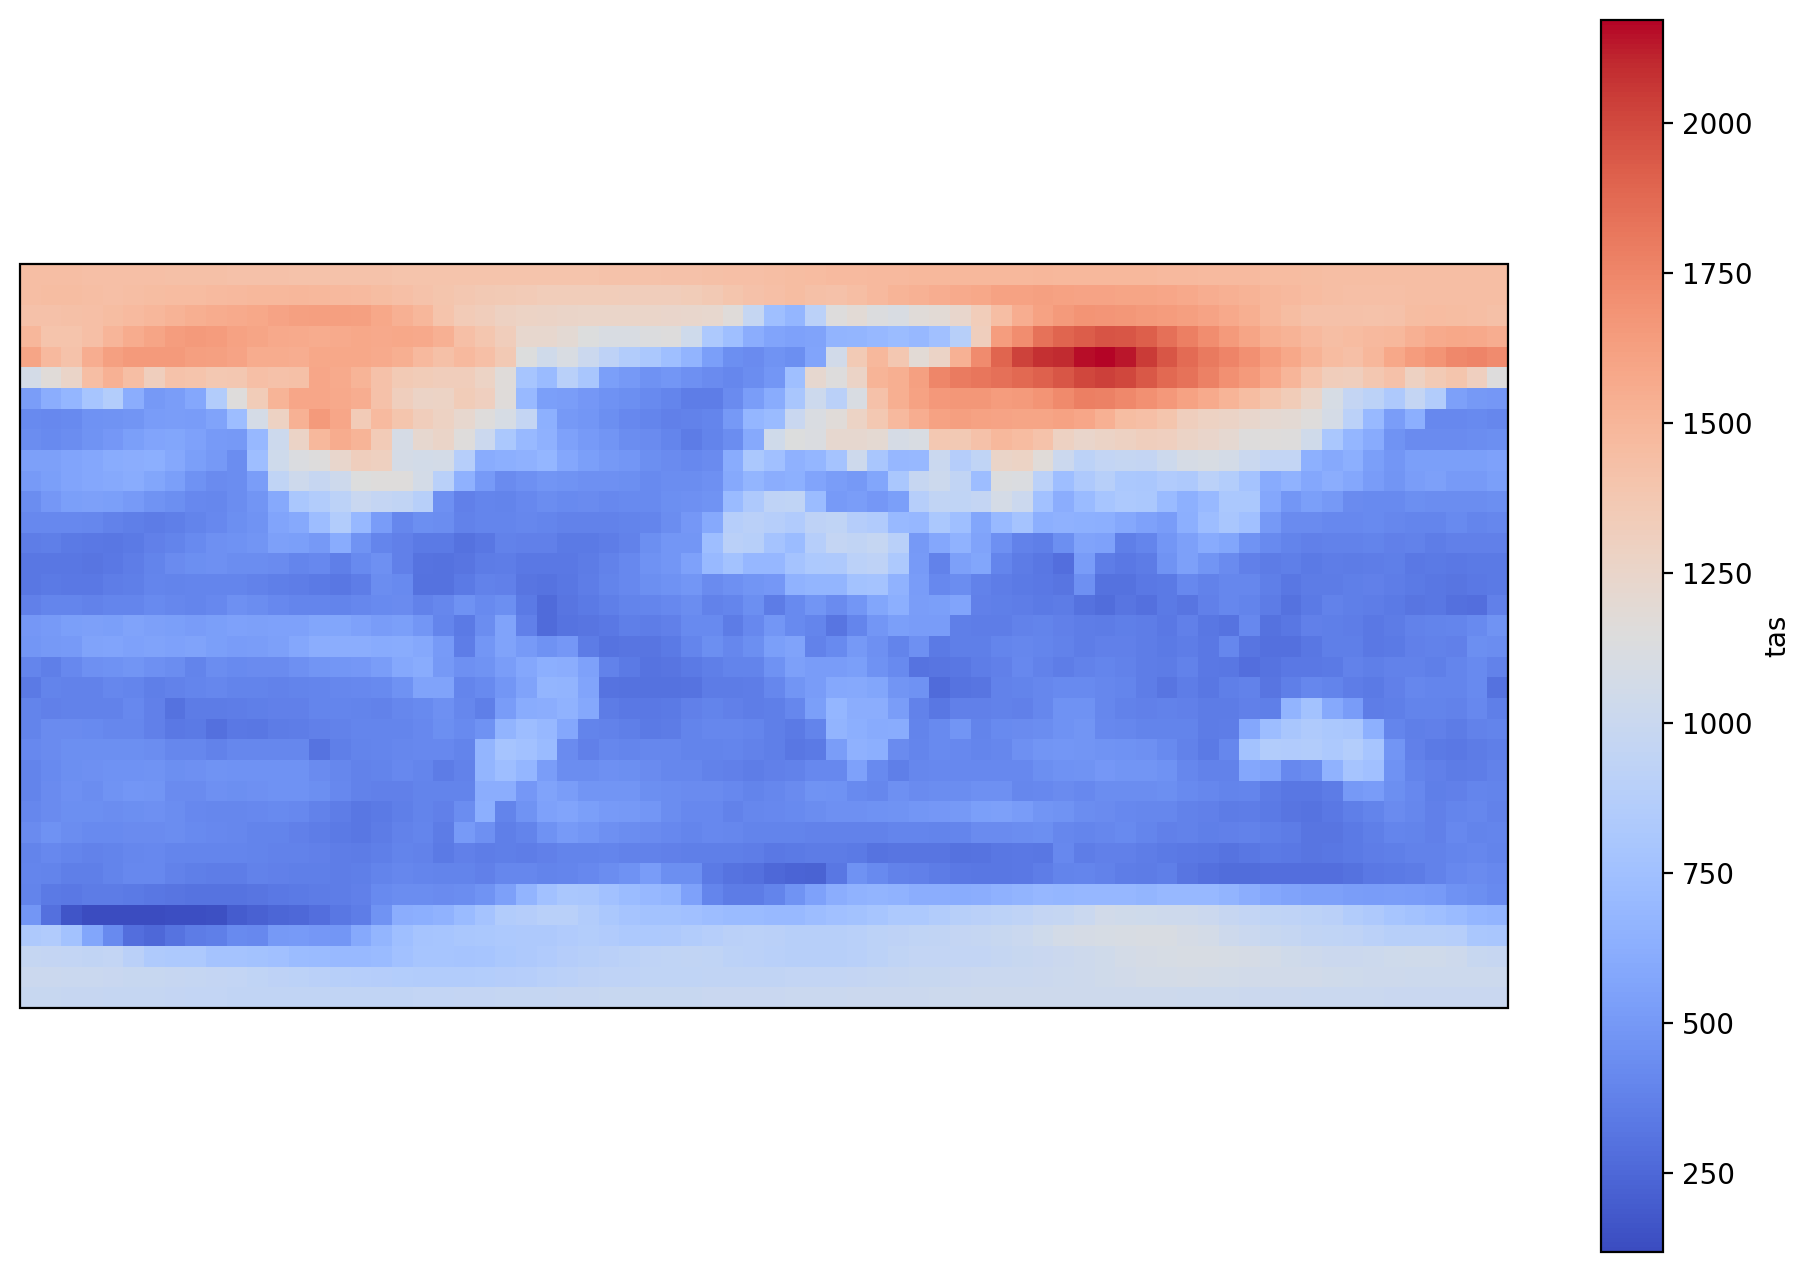

In [262]:
abs_anom = np.abs(ds)
# abs_anom.sum(dim=("latitude", "longitude")).plot()
abs_anom_all_time = abs_anom.sum(dim='time')
# max_where = np.where(abs_anom == abs_anom.max())
# print(abs_anom[max_where])
# print("----")
# print(abs_anom[np.where(abs_anom == abs_anom.min())])
p = abs_anom_all_time.plot(subplot_kws={"projection": ccrs.AzimuthalEquidistant()},transform=ccrs.AzimuthalEquidistant(), cmap="coolwarm")


Text(0.5, 1.0, 'Total anomaly deviation since 1960')

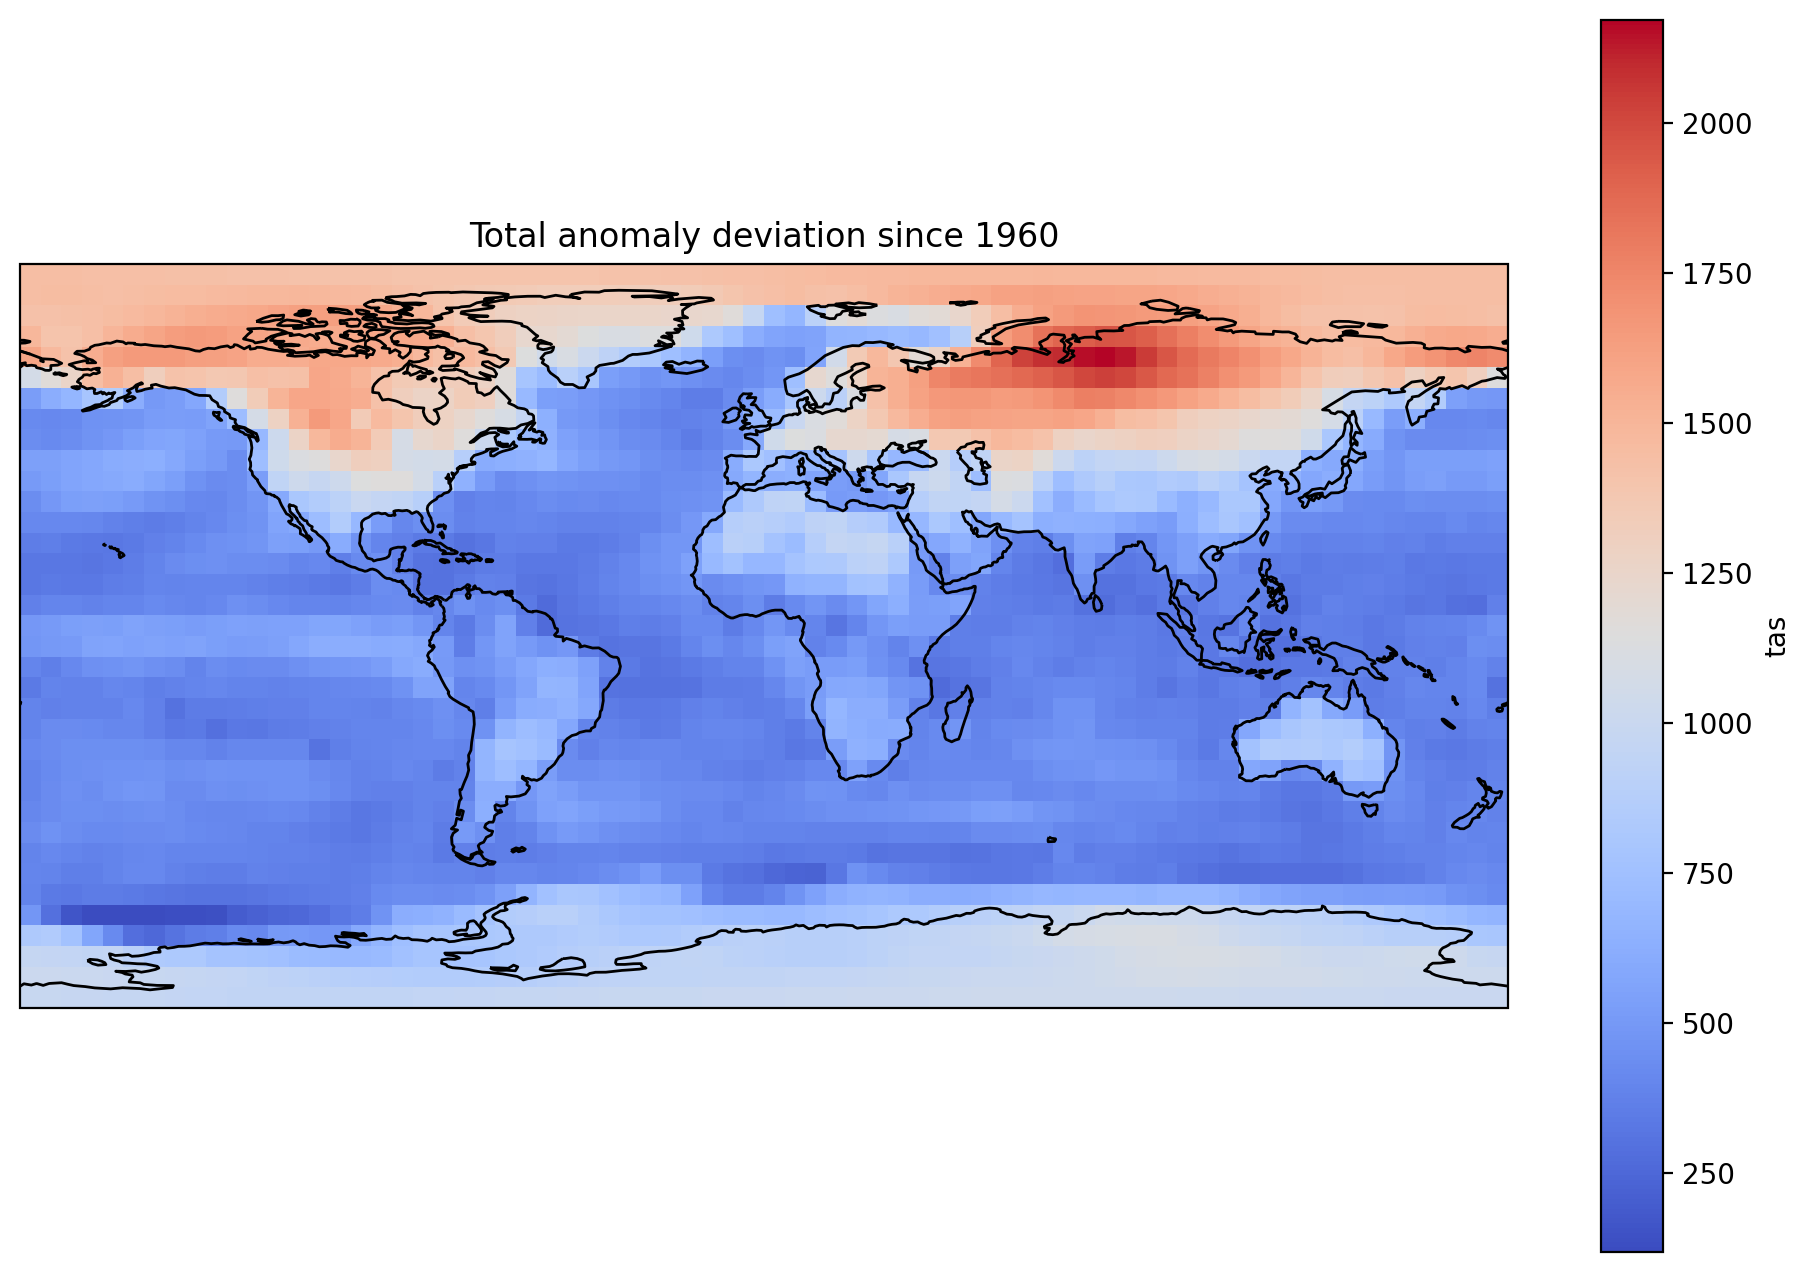

In [270]:
neg_anoms = np.clip(ds, None, 0)
# abs_anom.sum(dim=("latitude", "longitude")).plot()
abs_anom_all_time = abs_anom.sum(dim='time')
p = abs_anom_all_time.plot(subplot_kws={"projection": ccrs.PlateCarree()},transform=ccrs.PlateCarree(), cmap="coolwarm")
p.axes.coastlines()
plt.title("Total anomaly deviation since 1960")

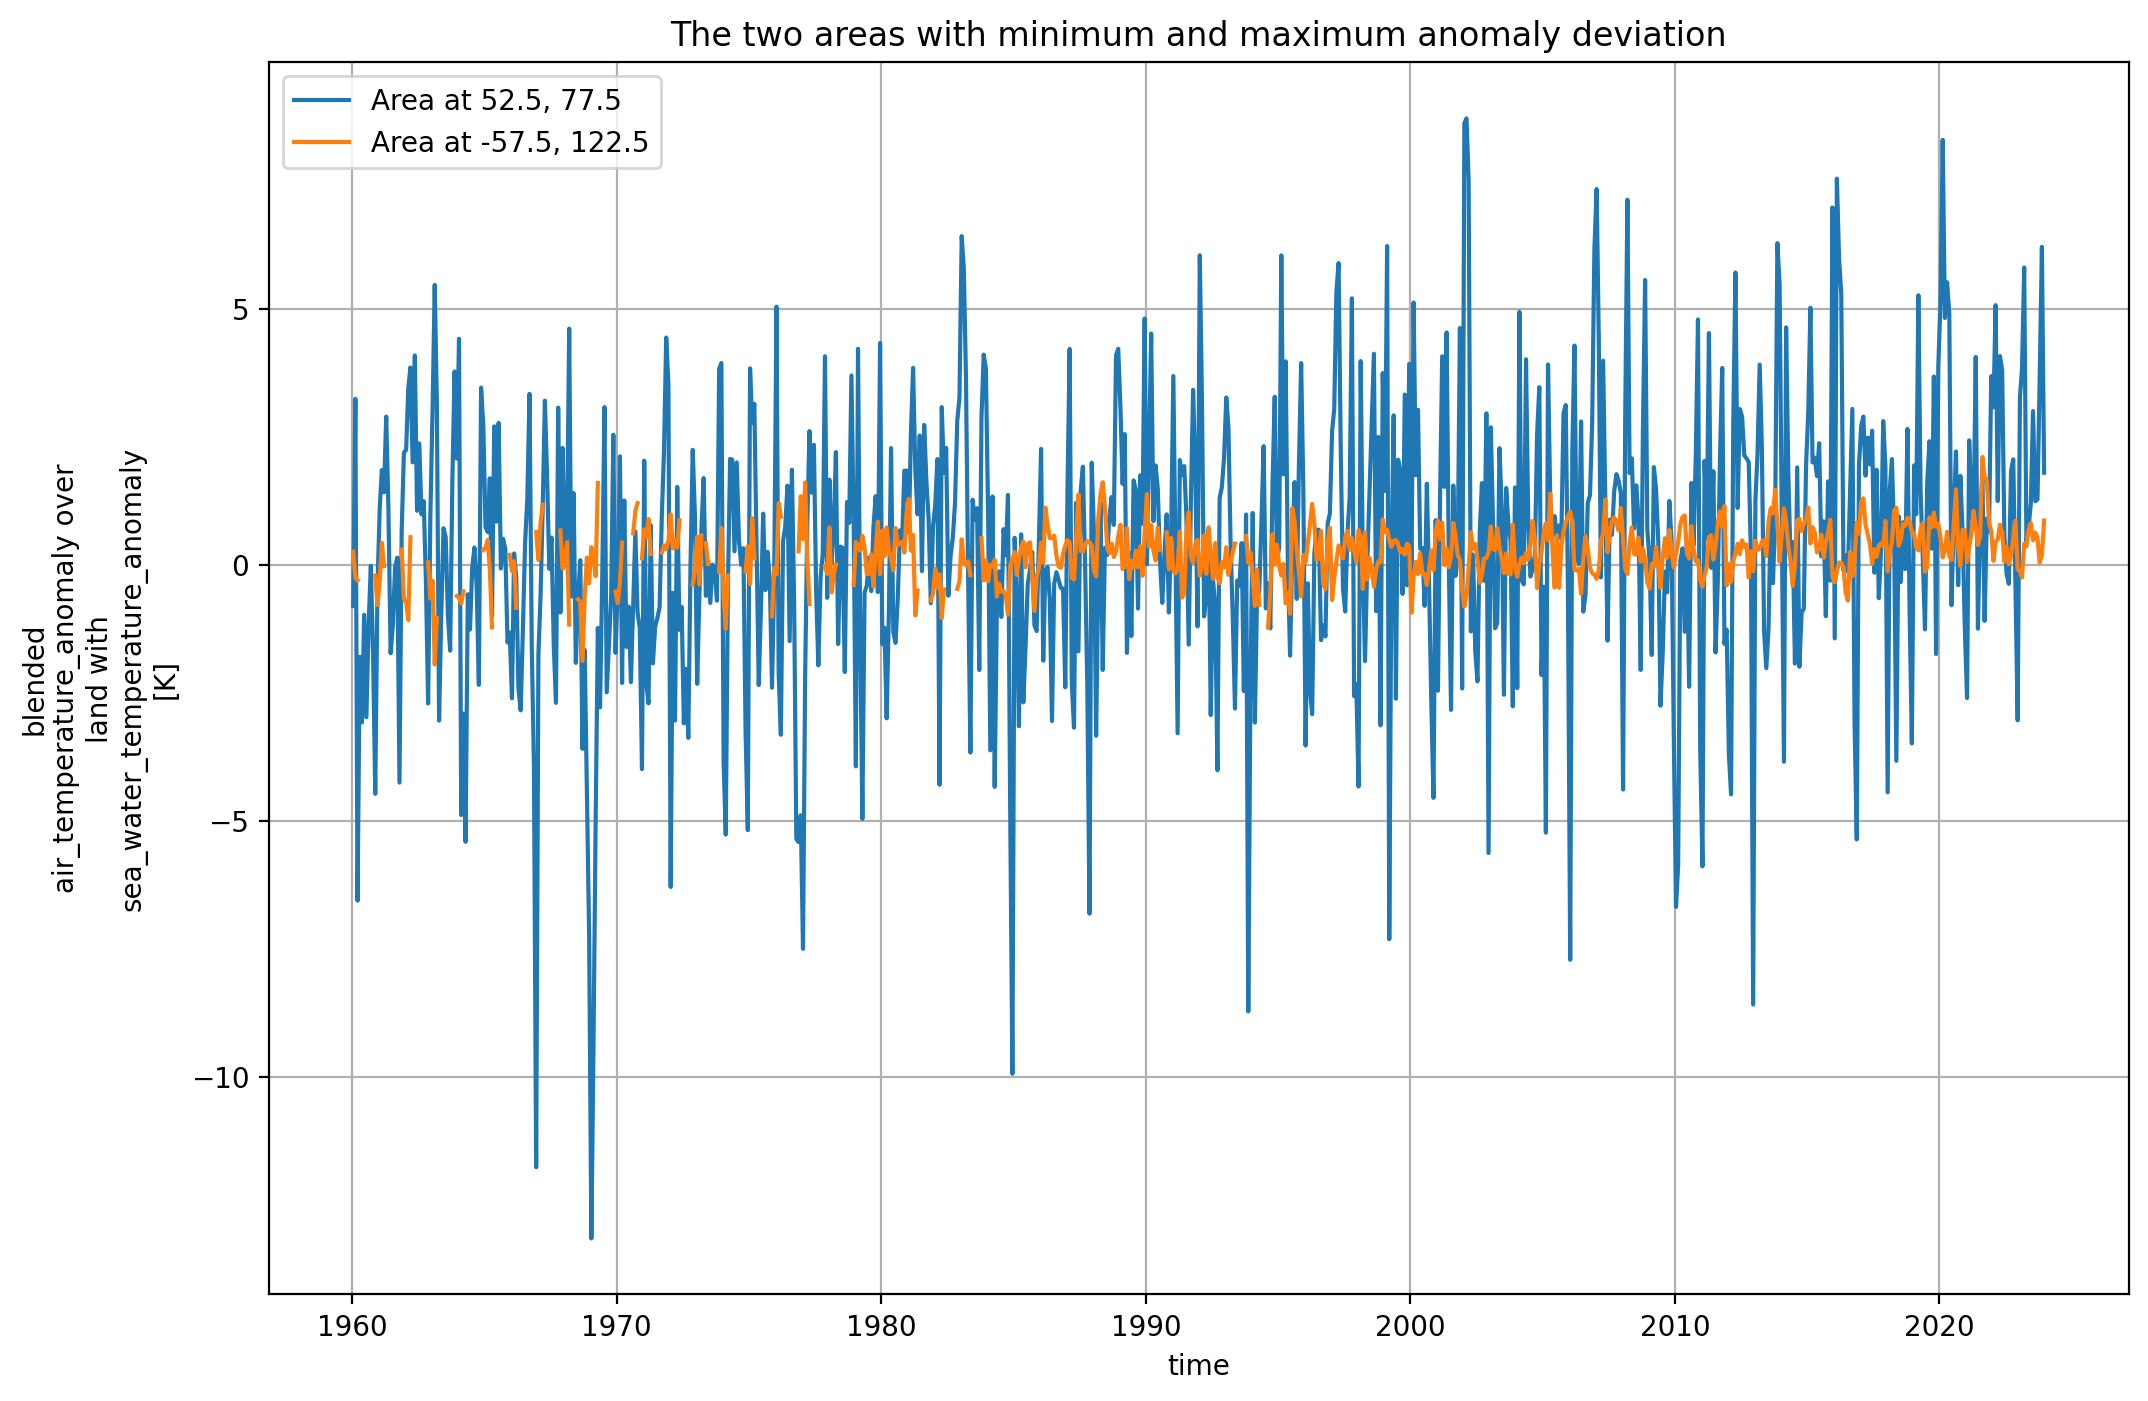

In [272]:
max_dev_lat, max_dev_long = 52.5, 77.5
max_dev_anoms = ds.sel(latitude=max_dev_lat, longitude=max_dev_long, method="nearest")
max_dev_anoms.plot(label=f"Area at {max_dev_lat}, {max_dev_long}")

min_dev_lat, min_dev_long = -57.5, 122.5
min_dev_anoms = ds.sel(latitude=-57.5, longitude=122.5, method="nearest")
min_dev_anoms.plot(label=f"Area at {min_dev_lat}, {min_dev_long}")
plt.legend()
plt.title("The two areas with minimum and maximum anomaly deviation")
plt.grid()

In [257]:
# TODO: fit regression for tempeture with year, think about starting to check linear term in time, quadratic term in time, what time period? 
# check that the assumptions of regression are met
# check 2012 paper for info on ensembles
# statistical slueth

(-57, 57.5)